$
\huge{
\textbf{
BaSTI Isochrones Only Notebook
}
}
$

In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [2]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
#create .dat files for the BaSTI isochrones along with monarch and astropy table
#import xarray as xr
files = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.isc_2mass')

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1])

for j in range(len(files)):
    tab = readbasti(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)

In [4]:
#Read in dat file
basti = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat')
tbasti = Table.from_pandas(basti)

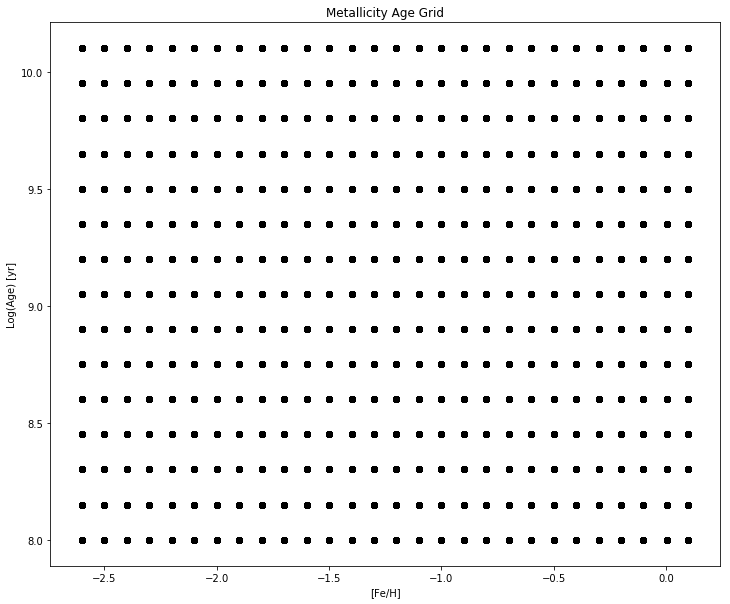

In [10]:
#Metallicity Age
plt.figure(figsize=[12,10])
plt.scatter(basti['FEH'],basti['LOGAGE'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('BaSTIgrid.pdf',bbox_inches='tight')
plt.show()

In [21]:
##########################
### Log(g) Calculation ###
##########################

'''Inserted into readbasti function'''

# mas = tbasti['MFIN']*(1.99*10**33) #mass in g
# tem = 10**tbasti['LOGT'] #T in K
# lum = (10**tbasti['LOGL'])*(3.9*10**33) #L in erg/s

# logg = np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum))

'Inserted into readbasti function'

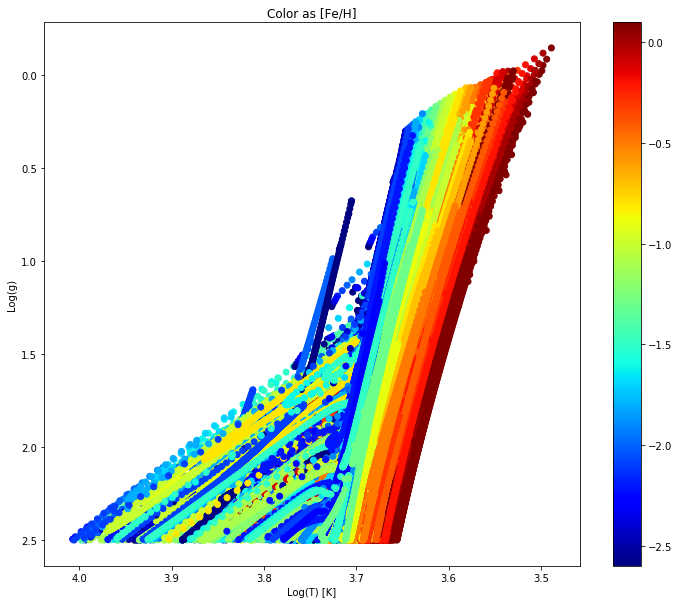

In [6]:
rgb = np.where(tbasti['LOGG']<2.5)

plt.figure(figsize=[12,10])
plt.scatter(tbasti['LOGT'][rgb],tbasti['LOGG'][rgb],c=tbasti['FEH'][rgb],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()

In [23]:
##############################
### Import statsmodels.api ###
##############################

import statsmodels.api as sm 

####################
### Prepare Data ###
####################

'''parameters: logTe, Hmag, [FE/H], logg'''\

logage = np.array(tbasti[rgb]['LOGAGE'].data)

J = np.array(tbasti[rgb]['JMAG'].data)
K = np.array(tbasti[rgb]['KMAG'].data)

logteff = np.array(tbasti[rgb]['LOGT'].data)
H = np.array(tbasti[rgb]['HMAG'].data)
feh = np.array(tbasti[rgb]['FEH'])
logg = np.array(tbasti[rgb]['LOGG'].data)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.088e+07
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        08:19:31   Log-Likelihood:             7.5928e+05
No. Observations:              423395   AIC:                        -1.519e+06
Df Residuals:                  423383   BIC:                        -1.518e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.4366      0.455    145.960      0.0

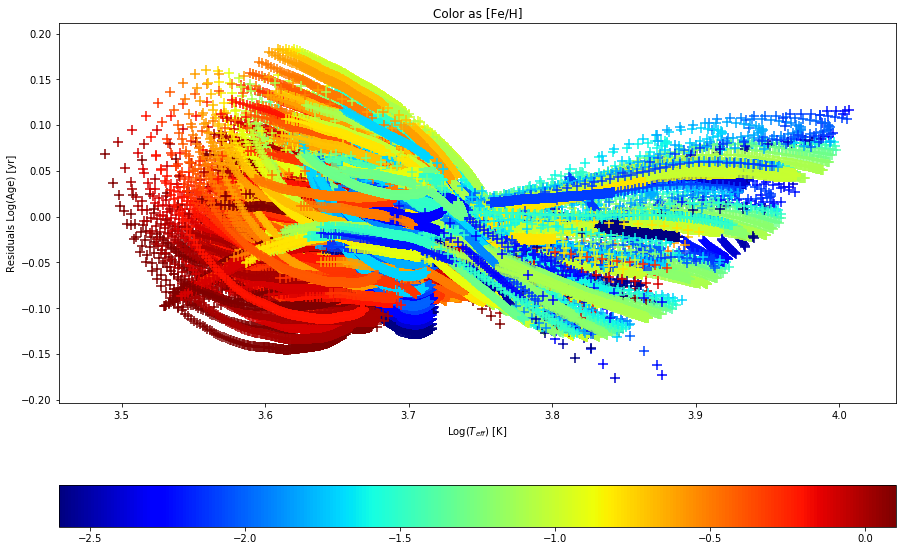

In [31]:
#################################
### Fit PARSEC model to BaSTI ###
#################################

pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,K),np.multiply(logteff,feh),\
                   np.multiply(logteff,logg),np.multiply(K,logg),\
                   logteff**2,K**2,logg**2]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
plt.show()

print(mad)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.050e+07
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        08:19:39   Log-Likelihood:             6.5663e+05
No. Observations:              423395   AIC:                        -1.313e+06
Df Residuals:                  423387   BIC:                        -1.313e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.9634      0.426     42.156      0.0

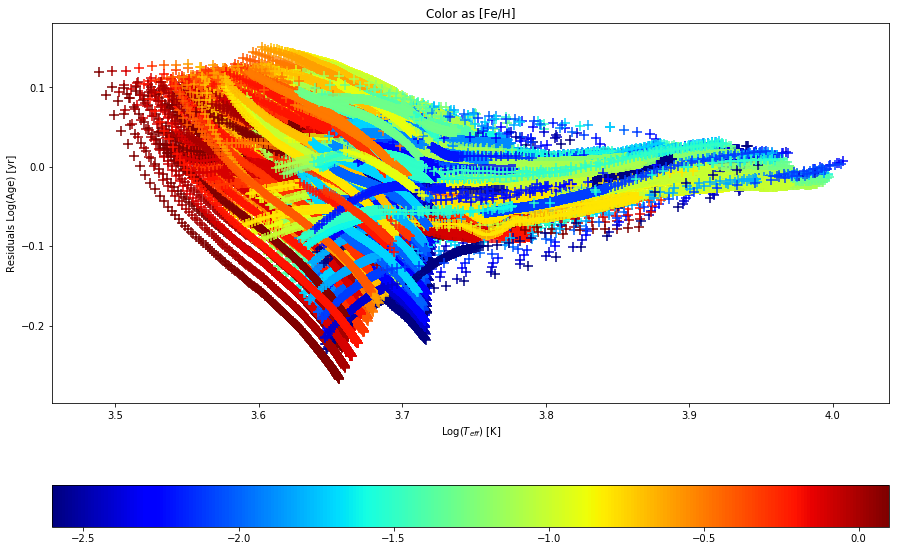

In [32]:
#################################
### Fit Other models to BaSTI ###
#################################

pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,feh),logteff**2,logg**2]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
plt.show()

print(mad(residual))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.180e+07
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        09:04:32   Log-Likelihood:             7.3422e+05
No. Observations:              423395   AIC:                        -1.468e+06
Df Residuals:                  423385   BIC:                        -1.468e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        598.7746      9.368     63.915      0.0

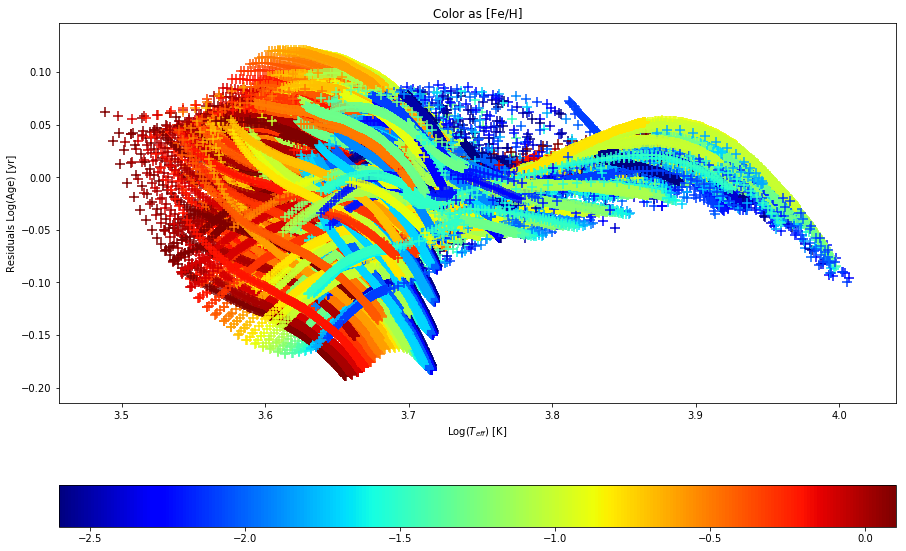

0.02363355790548205


In [47]:
pmodl = np.array([logteff,K,feh,logg,np.multiply(logteff,K),np.multiply(logteff,logg),\
                  logteff**2,feh**2,logteff**3]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.savefig('BaSTIresiduals.pdf',bbox_inches='tight')
plt.show()

print(mad(residual))